# Temporal analysis 

In this notebook we show some examples of how to apply EpiFRIenDs using temporal data

## Importing modules 

We first import the modules required from this notebook. Notice that, apart from the packages already required by EpiFRIenDs, matplotlib is also necessary here.

In [1]:
import numpy as np
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
from matplotlib import cm, colors
%matplotlib inline
from epifriends import epifriends
import os

## Defining functions

In [2]:
def generate_mock_data_temp(population_size, positivity_rate, positive_distribution, \
                            start_date = '2020', end_date = '2022', seed = None, \
                            save = True, output_file = 'mock_dataframe.csv', nclusters = 4):
    """
    This method generates temporal mock data of a spatial distribution
    of negative and positive cases.

    Parameters:
    -----------
    population_size: int
        Sample size
    positivity_rate: float
        Fraction of positive cases
    positive_distribution: str {'rand', 'clustered', 'sinusoidal'}
        Option for the distribution of positive cases
    start_date: pd.Timestamp or str
        Starting date
    end_date: pd.Timestamp or str
        Ending date
    seed: int
        Random seed for the random number generation
    save: bool
        If true, the dataframe is saved as a csv
    output_file: str
        Name of output file
    nclusters: int
        Number of clusters simulated for positive_distribution = clustered

    Returns:
    --------
    x_rand: np.array
        Positions in x-axis
    y_rand: np.array
        Positions in y-axis
    position_rand: np.ndarray
        2D-vector with x and y positions
    positive: np.array
        Boolean mask for positive cases
    test_rand: np.array
        Test results, 1 for positive, 0 for negative
    dates_rand: pd.Series
        Dates of the cases
    mock_df: pd.DataFrame
        Dataframe of the mock data
    """
    if seed is not None:
        np.random.seed(seed)
    #Negative cases
    x_rand = np.random.rand(int(population_size*(1 - positivity_rate)))
    y_rand = np.random.rand(int(population_size*(1 - positivity_rate)))
    dates_rand = random_dates(start_date, end_date, n=len(x_rand))
    #Positive cases
    if positive_distribution == 'rand':
        x_rand_p = np.random.rand(int(population_size*positivity_rate))
        y_rand_p = np.random.rand(int(population_size*positivity_rate))
        dates_rand_p = random_dates(start_date, end_date, n=len(x_rand_p))
        #Concatenating all cases
        x_rand = np.concatenate((x_rand, x_rand_p))
        y_rand = np.concatenate((y_rand, y_rand_p))
        dates_rand = np.concatenate((dates_rand, dates_rand_p))
    elif positive_distribution == 'sinusoidal':
        x_rand_p = np.random.rand(int(population_size*positivity_rate))
        y_rand_p = .5 + .5*np.sin(10*x_rand_p)
        dates_rand_p = random_dates(start_date, end_date, n=len(x_rand_p), mode = 'normal')
        #Concatenating all cases
        x_rand = np.concatenate((x_rand, x_rand_p))
        y_rand = np.concatenate((y_rand, y_rand_p))
        dates_rand = np.concatenate((dates_rand, dates_rand_p))
    elif positive_distribution == 'clustered':
        for i in range(nclusters):
            x_rand_p = np.random.normal(.1 + .8*np.random.rand(), .05, int(population_size*positivity_rate/nclusters))
            y_rand_p = np.random.normal(.1 + .8*np.random.rand(), .05, int(population_size*positivity_rate/nclusters))
            dates_rand_p = random_dates(start_date, end_date, n=len(x_rand_p), mode = 'normal')
            #Concatenating all cases
            x_rand = np.concatenate((x_rand, x_rand_p))
            y_rand = np.concatenate((y_rand, y_rand_p))
            dates_rand = np.concatenate((dates_rand, dates_rand_p))
    #2D vector for positions
    position_rand = np.array([x_rand,y_rand]).T
    #Defining positivity and test result
    positive = np.arange(population_size) > population_size*(1 - positivity_rate)
    test_rand = np.array(positive, dtype = float)
    mock_df = get_mock_dataframe_temp(x_rand, y_rand, test_rand, dates_rand, save, output_file)
    return x_rand, y_rand, position_rand, positive, test_rand, dates_rand, mock_df

def get_mock_dataframe_temp(x_rand, y_rand, test_rand, dates_rand, save = True, output_file = 'mock_dataframe.csv'):
    """
    This method creates a dataframe of the temporal mock data.

    Parameters:
    -----------
    x_rand: np.array
        Positions in x-axis
    y_rand: np.array
        Positions in y-axis
    test_rand: np.array
        Test results, 1 for positive, 0 for negative
    save: bool
        If true, the dataframe is saved as a csv
    output_file: str
        Name of output file

    Returns:
    --------
    mock_df: pd.DataFrame
        Dataframe of the mock data
    """
    mock_df = pd.DataFrame(
    {
        'id' : np.arange(len(x_rand), dtype = int),
        'x' : x_rand,
        'y' : y_rand,
        'test' : test_rand,
        'case_count' : np.ones_like(x_rand),
        'date' : dates_rand
    })
    mock_df = geopandas.GeoDataFrame(mock_df, geometry = geopandas.points_from_xy(mock_df['x'], mock_df['y']))
    if save:
        mock_df.to_csv(output_file)
    return mock_df

In [3]:
def random_dates(start, end, n=10, mode = 'rand'):
    """
    This method generates random dates within a time range.
    
    Parameters:
    -----------
    start: pd.Timestamp or str
        Starting date
    end: pd.Timestamp or str
        Ending date
    n: int
        Number of generated dates
    mode: str
        It specifies the distribution of the random dates
    
    Returns:
    --------
    dates: pd.Series
        Array of randomly generated dates
    """
    start_u = pd.to_datetime(start).value//10**9
    end_u = pd.to_datetime(end).value//10**9
    
    if mode == 'rand':
        dates = pd.to_datetime(np.random.randint(start_u, end_u, n), unit='s')
    elif mode == 'normal':
        centre = np.random.randint(start_u, end_u)
        dates = np.random.normal(centre, 10**7, n)
        unfit = (dates < start_u)|(dates > end_u)
        dates[unfit] = np.random.randint(start_u, end_u, np.sum(unfit))
        dates = pd.to_datetime(dates, unit='s')
    else:
        print("ERROR:unvalid mode for generating dates", mode)
    return dates

def generate_mock_data(population_size, positivity_rate, positive_distribution, \
                       seed = None, save = True, output_file = 'mock_dataframe.csv'):
    """
    This method generates mock data of a spatial distribution
    of negative and positive cases.

    Parameters:
    -----------
    population_size: int
        Sample size
    positivity_rate: float
        Fraction of positive cases
    positive_distribution: str {'rand', 'clustered', 'sinusoidal'}
        Option for the distribution of positive cases
    seed: int
        Random seed for the random number generation
    save: bool
        If true, the dataframe is saved as a csv
    output_file: str
        Name of output file

    Returns:
    --------
    x_rand: np.array
        Positions in x-axis
    y_rand: np.array
        Positions in y-axis
    position_rand: np.ndarray
        2D-vector with x and y positions
    positive: np.array
        Boolean mask for positive cases
    test_rand: np.array
        Test results, 1 for positive, 0 for negative
    mock_df: pd.DataFrame
        Dataframe of the mock data
    """
    if seed is not None:
        np.random.seed(seed)
    #Negative cases
    x_rand = np.random.rand(int(population_size*(1 - positivity_rate)))
    y_rand = np.random.rand(int(population_size*(1 - positivity_rate)))
    #Positive cases
    if positive_distribution == 'rand':
        x_rand_p = np.random.rand(int(population_size*positivity_rate))
        y_rand_p = np.random.rand(int(population_size*positivity_rate))
        #Concatenating all cases
        x_rand = np.concatenate((x_rand, x_rand_p))
        y_rand = np.concatenate((y_rand, y_rand_p))
    elif positive_distribution == 'sinusoidal':
        x_rand_p = np.random.rand(int(population_size*positivity_rate))
        y_rand_p = .5 + .5*np.sin(10*x_rand_p)
        #Concatenating all cases
        x_rand = np.concatenate((x_rand, x_rand_p))
        y_rand = np.concatenate((y_rand, y_rand_p))
    elif positive_distribution == 'clustered':
        for i in range(4):
            x_rand_p = np.random.normal(.1 + .8*np.random.rand(), .05, int(population_size*positivity_rate/4))
            y_rand_p = np.random.normal(.1 + .8*np.random.rand(), .05, int(population_size*positivity_rate/4))
            #Concatenating all cases
            x_rand = np.concatenate((x_rand, x_rand_p))
            y_rand = np.concatenate((y_rand, y_rand_p))
    #2D vector for positions
    position_rand = np.array([x_rand,y_rand]).T
    #Defining positivity and test result
    positive = np.arange(population_size) > population_size*(1 - positivity_rate)
    test_rand = np.array(positive, dtype = float)
    mock_df = get_mock_dataframe(x_rand, y_rand, test_rand, save, output_file)
    return x_rand, y_rand, position_rand, positive, test_rand, mock_df

def get_mock_dataframe(x_rand, y_rand, test_rand, save = True, output_file = 'mock_dataframe.csv'):
    """
    This method creates a dataframe of the mock data.

    Parameters:
    -----------
    x_rand: np.array
        Positions in x-axis
    y_rand: np.array
        Positions in y-axis
    test_rand: np.array
        Test results, 1 for positive, 0 for negative
    save: bool
        If true, the dataframe is saved as a csv
    output_file: str
        Name of output file

    Returns:
    --------
    mock_df: pd.DataFrame
        Dataframe of the mock data
    """
    mock_df = pd.DataFrame(
    {
        'id' : np.arange(len(x_rand), dtype = int),
        'x' : x_rand,
        'y' : y_rand,
        'test' : test_rand,
        'case_count' : np.ones_like(x_rand),
    })
    mock_df['date'] = random_dates('2020', '2022', n=len(x_rand))
    mock_df = geopandas.GeoDataFrame(mock_df, geometry = geopandas.points_from_xy(mock_df['x'], mock_df['y']))
    if save:
        mock_df.to_csv(output_file)
    return mock_df

def hist_timelifes(list_catalogues):
    """
    This method plots a histogram of the lifetime of the detected clusters. 
    
    Parameters:
    -----------
    list_catalogues:  list of pandas.DataFrame
        List of EpiFRIenDs catalogues, each element of the list
        corresponding to the EpiFRIenDs catalogue of each timestep
    
    Returns: 
    --------
    Matplotlib plot with histogram
    """
    all_tempids = epifriends.get_label_list(list_catalogues, label = 'tempID')
    if len(all_tempids) > 0:
        lifetimes = []
        for tempid in all_tempids:
            for t in list_catalogues:
                if tempid in t['tempID'].unique():
                    mask = t['tempID'] == tempid
                    lifetimes.append(np.mean(t['lifetime'].loc[mask]))
                    break
        plt.hist(lifetimes, 50)
        plt.xlabel("Time duration of clusters ( number of time steps)")
        plt.ylabel("Number of clusters")
        plt.show()
        
def lifetime_timeline(list_catalogues, mean_dates, time_steps):
    """
    This method visualised the size evolution of the clusters in time 
    and colour-codes them with their total lifetime.
    
    Parameters:
    -----------
    list_catalogues:  list of pandas.DataFrame
        List of EpiFRIenDs catalogues, each element of the list
        corresponding to the EpiFRIenDs catalogue of each timestep
    mean_date: list
        List of dates corresponding to the median time in each time window
    time_steps: int
        Number of days that the time window is shifted in each time step
        
    Returns: 
    --------
    Matplotlib plot with the size evolution and lifetimes of clusters
    """
    tempids = epifriends.get_label_list(list_catalogues, label = 'tempID')
    lifetimes = epifriends.get_label_list(list_catalogues, label = 'lifetime')

    for i, tempid in enumerate(tempids):
        num_cases = []
        dates = []
        min_date = list_catalogues[0]['Date'].min()
        for f in range(len(list_catalogues)):
            dates.append(min_date + pd.to_timedelta(f*time_steps, unit = 'D'))
            if tempid in list_catalogues[f]['tempID'].unique():
                mask = list_catalogues[f]['tempID'] == tempid
                num_cases.append(np.sum(list_catalogues[f][mask]['total']))
                lifetime = list_catalogues[f][mask]['lifetime'].iloc[0]
            else:
                num_cases.append(0)
        dates = pd.to_datetime(dates)
        num_cases = np.array(num_cases)

        plt.plot(mean_dates, num_cases, color = cm.turbo(lifetime/max(lifetimes)), \
                lw = 2)
    plt.xlabel("Date")
    plt.xticks(mean_dates[::int(len(mean_dates)/3)])
    plt.ylabel("Number of cases in cluster")
    plt.ylim(ymin = 0.1)
    cNorm = colors.Normalize(vmin=0, vmax=max(lifetimes))
    plt.colorbar(cm.ScalarMappable(norm = cNorm, cmap='turbo'), label = 'Lifetime')
    plt.show()

## Create mock data

Here we define and create the mock data for the examples from this notebook.

In [4]:
#This defines the path to store the data generated if desired
mock_data_path = "~/Desktop/"

In [5]:
#Fixing a random seed to reproduce the results
seed = 290357568
#Defining the population size and positivity rate of the mock data
population_size = 1000
positivity_rate = .2

#Generating random distribution of positives
file_name = 'mock_data_rand.csv'
x_rand, y_rand, position_rand, positive_rand, test_rand, dates, \
mock_rand = generate_mock_data_temp(population_size, positivity_rate, 'rand', seed = seed, \
                               output_file = os.path.join(mock_data_path, file_name), \
                               save = False)

In this plot we visualise the generated mock data. The colours of the points represent the date of the samples, and those marked with a red edge are the positive cases:

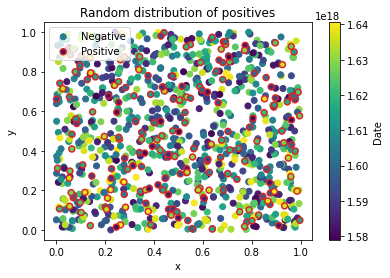

In [6]:

#Plots
plt.scatter(x_rand[test_rand == 0], y_rand[test_rand == 0], c = mock_rand['date'][test_rand == 0], \
            cmap = 'viridis', label = 'Negative')
plt.scatter(x_rand[test_rand == 1], y_rand[test_rand == 1], c = mock_rand['date'][test_rand == 1], \
            cmap = 'viridis', edgecolor = 'tab:red', label = 'Positive', lw = 1.5)
plt.colorbar(label = 'Date')
plt.title("Random distribution of positives")
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Implementing EpiFRIenDs

Here we define the required parameters to run the method `temporal_catalogue` that outputs an EpiFRIenDs catalogue in each of the defined time steps:

In [7]:
#Parameters
#linking distance to link cases in space
link_d = .1
#Minimum number of positive cases within link_d to link them
min_neighbours = 2
#Width of the time window (in number of days) used to select the cases 
#in each time step. In this case, cases within 6 months are included
time_width = 180
#Number of days moved forward in each time step. In this case, each 
#time step include cases 3 months later than the previous step. Given 
#that time_width = 180, each step includes the last 90 from the previous 
#time step
time_steps = 90
#Initial date of first time step
min_date = mock_rand['date'].min()
#Final date of last time step
max_date = mock_rand['date'].max()

Here we run the `temporal_catalogue` method and obtain: 

- epi_catalogue_list: a list where each element represents a time step and contains its corresponding catalogue. 

- mean_date: a list with the median date of the time window of each time step

In [8]:
epi_catalogue_list, mean_date = epifriends.temporal_catalogue(x_rand, y_rand, positive_rand, dates, link_d, min_neighbours, \
                       time_width, min_date, max_date, time_steps)

Data with unknown positions will be excluede from the analysis
missing test results will be kept as unknown for the analysis


Here we visualise the detected clusters in each step, showing one scatter plot for each time step with: 

- The cases not belonging to any cluster in grey (the positive cases marked with a red edge)

- The cases belonging to a cluster colour-coded with their cluster ID (the positive cases marked with a red edge)

- The p-value written next to each of the cluster

Notice that negative cases can in some cases belong to two (or more) different clusters (if they are closer than `link_d` to two (or more) positive cases from two (or more) different clusters. In this case, the colour has been assigned to the last of the plotted clusters.

Time step number 0


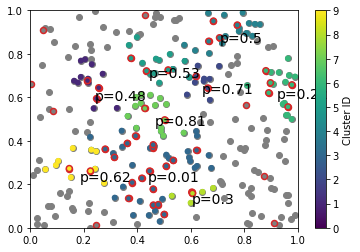

Time step number 1


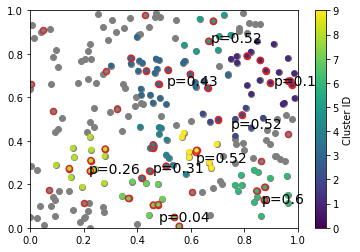

Time step number 2


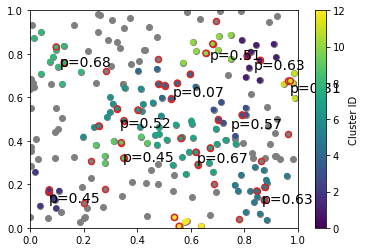

Time step number 3


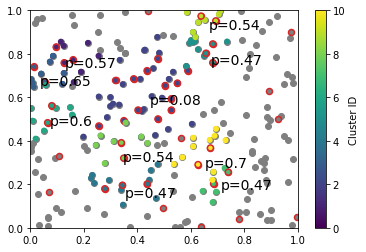

Time step number 4


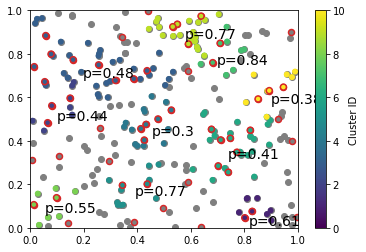

Time step number 5


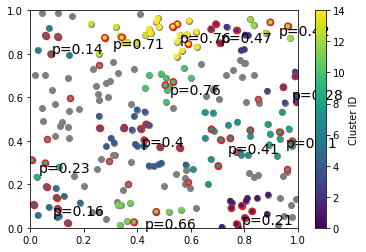

Time step number 6


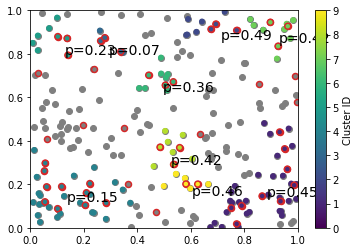

In [9]:
#we loop through all the time steps
step_num = 0
while min_date + pd.to_timedelta(time_steps*step_num + time_width, unit = 'D') <= max_date:
    print("Time step number", step_num)
    #select data in time window
    selected_data = (dates >= min_date + pd.to_timedelta(time_steps*step_num, unit = 'D'))& \
                    (dates <= min_date + pd.to_timedelta(time_steps*step_num + time_width, unit = 'D'))
    #show data spatial distribution
    #Plotting negative cases
    plt.scatter(x_rand[selected_data&np.invert(positive_rand)], \
                y_rand[selected_data&np.invert(positive_rand)], c = 'tab:grey')
    #Plotting positive cases
    plt.scatter(x_rand[selected_data&positive_rand], \
                y_rand[selected_data&positive_rand], c = 'tab:grey', \
                edgecolor = 'tab:red', label = 'Positive', lw = 1.5)
    #For each EpiFRIenDs cluster in this time step, plot its cases colour coded by the mean positivity rate
    for epi in range(len(epi_catalogue_list[step_num])):
        indeces = np.array(epi_catalogue_list[step_num].iloc[epi]['indeces'], dtype = int)
        vmin = 0 
        vmax = epi_catalogue_list[step_num]['id'].max() #1 #np.max(np.array(fof_cat['mean_pr']))
        if len(x_rand[selected_data][indeces]) > 0:
            plt.scatter(x_rand[selected_data][indeces], y_rand[selected_data][indeces], \
                        c = np.ones(len(indeces))*(epi_catalogue_list[step_num].iloc[epi]['id'] - vmin/(vmax-vmin)), \
                        cmap = 'viridis', vmin = vmin, vmax = vmax, edgecolor = 'tab:red', \
                        lw = 1.5*positive_rand[selected_data][indeces])
            plt.annotate('p='+str(round(epi_catalogue_list[step_num].iloc[epi]['p'],2)), \
                         xy = [epi_catalogue_list[step_num].iloc[epi]['mean_position_pos'][0], \
                               epi_catalogue_list[step_num].iloc[epi]['mean_position_pos'][1]-.05], 
                        fontsize = 14)
    plt.colorbar(label = 'Cluster ID')
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.show()
    step_num +=1

Here we show the number of clusters detected as a function of time: 

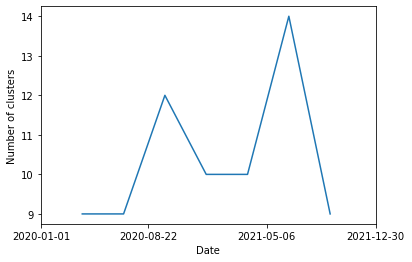

In [10]:
#Showing number of clusters per time step
num_clusters = [len(i) for i in epi_catalogue_list]
plt.plot(mean_date, num_clusters)
plt.xlabel('Date')
plt.ylabel('Number of clusters')
plt.xticks(pd.to_datetime(dates).sort_values()[::int(len(dates)/3)-1])
plt.show()

Once we have the list of temporal catalogues `epi_catalogue_list`, we can add the temporal ID of the EpiFRIenDs clusters. This is done by assigning the same temporal ID to the clusters that are closer in time than the specificed linking time steps `linking_time` and closer in space that a specified `linking_dist`. Notice that `linking_dist` can be different than `link_d`, since the first is used to link clusters from different timesteps as assign to them the same temporal ID, and the latter is used to detect the clusters and assign their EpiFRIenDs ID. 

In [11]:
#Number of time steps considered to link their temporal clusters
linking_time = 3
#Spatial distance of clusters within this linking_time to assign the same temporal ID
linking_dist = .15

#Get temporal IDs
epi_catalogue_list = epifriends.add_temporal_id(epi_catalogue_list, linking_time, linking_dist, get_timelife = True)

Notice that we asked in `add_temporal_id` to get the timelifes of the clusters through `get_timelife = True`. This is the default implementation, but if the timelifes are not obtained at this moment, they can just be added by the command: 

`epi_catalogue_list = epifriends.get_lifetimes(epi_catalogue_list)`

The computation of the timelifes adds to the catalogues the following variables: 

- 'first_timestep': the first time step in which the temporal ID of each cluster appears

- 'last_timestep': the first time step in which the temporal ID of each cluster appears

- 'timelife' : the number of time steps between the first and the last

Notice that, depending on the values of linking_time, we can find some time steps where we find no clusters of a given temporal ID between their first and last time steps.

With the following function we can obtain a list of all the values of a given variable (in this case 'tempID') within the list of EpiFRIenDs catalogues: 

In [12]:
#List of timeIDs within the catalogues 
timeids = epifriends.get_label_list(epi_catalogue_list, 'tempID')
print("Temporal IDs:", timeids)

Temporal IDs: [1. 2. 3. 4. 5. 6.]


Here we visualise the results again, but colour-coding the clusters with their 'tempID'

Time step number 0


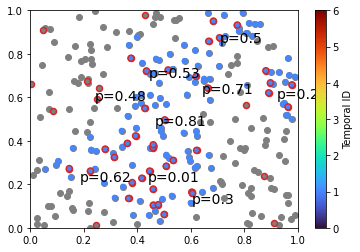

Time step number 1


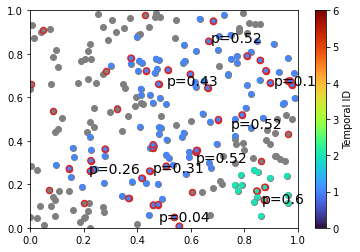

Time step number 2


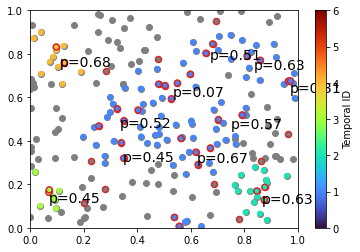

Time step number 3


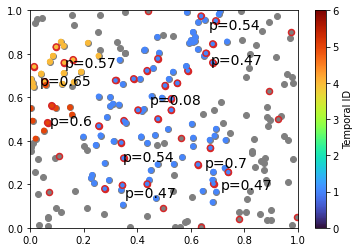

Time step number 4


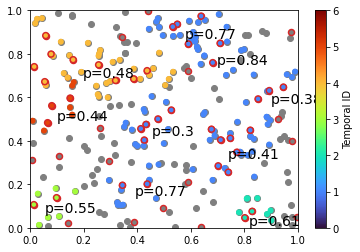

Time step number 5


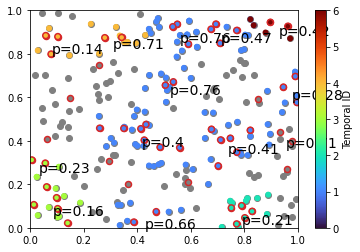

Time step number 6


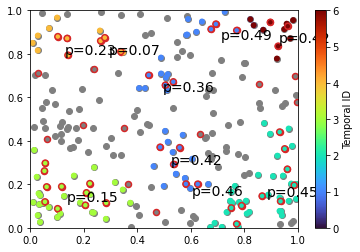

In [13]:
#we loop through all the time steps
step_num = 0
while min_date + pd.to_timedelta(time_steps*step_num + time_width, unit = 'D') <= max_date:
    print("Time step number", step_num)
    #select data in time window
    selected_data = (dates >= min_date + pd.to_timedelta(time_steps*step_num, unit = 'D'))& \
                    (dates <= min_date + pd.to_timedelta(time_steps*step_num + time_width, unit = 'D'))
    #show data spatial distribution
    #Plotting negative cases
    plt.scatter(x_rand[selected_data&np.invert(positive_rand)], \
                y_rand[selected_data&np.invert(positive_rand)], c = 'tab:grey')
    #Plotting negative cases
    plt.scatter(x_rand[selected_data&positive_rand], \
                y_rand[selected_data&positive_rand], c = 'tab:grey', \
                edgecolor = 'tab:red', label = 'Positive', lw = 1.5)
    #For each EpiFRIenDs cluster in this time step, plot its cases colour coded by the mean positivity rate
    for epi in range(len(epi_catalogue_list[step_num])):
        indeces = np.array(epi_catalogue_list[step_num].iloc[epi]['indeces'], dtype = int)
        vmin = 0
        vmax = timeids.max()
        plt.scatter(x_rand[selected_data][indeces], y_rand[selected_data][indeces], \
                    c = np.ones(len(indeces))*(epi_catalogue_list[step_num].iloc[epi]['tempID'] - vmin/(vmax-vmin)), \
                    cmap = 'turbo', vmin = vmin, vmax = vmax, edgecolor = 'tab:red', \
                    lw = 1.5*positive_rand[selected_data][indeces])
        plt.annotate('p='+str(round(epi_catalogue_list[step_num].iloc[epi]['p'],2)), \
                     xy = [epi_catalogue_list[step_num].iloc[epi]['mean_position_pos'][0], \
                           epi_catalogue_list[step_num].iloc[epi]['mean_position_pos'][1]-.05], 
                    fontsize = 14)
    plt.colorbar(label = 'Temporal ID')
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.show()
    step_num +=1

Here we show a histogram of the lifetimes of the detected clusters (each 'tempID' is represented once):

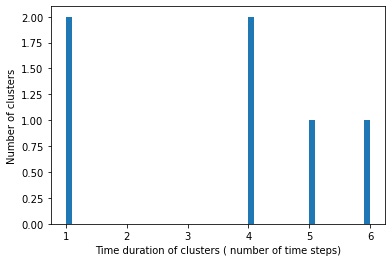

In [14]:
hist_timelifes(epi_catalogue_list)

Finally, In the following plot we show how the different clusters evolve in time by showing their total number of cases in each time step. Each line represents a 'tempID' and the colour shows its lifetime measured as the number of timesteps between its first and last detection

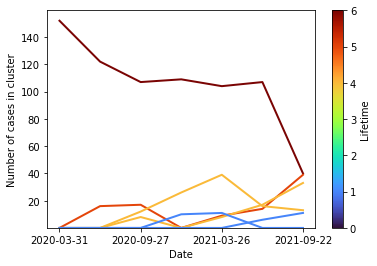

In [15]:
lifetime_timeline(epi_catalogue_list, mean_date, time_steps)

Finally, here we show another example simulating 10 clusters around 10 random times, now with finer time resolution in the analysis and with a p-value cut of 0.05: 

In [16]:
#Fixing a random seed to reproduce the results
seed = 548384364
#Defining the population size and positivity rate of the mock data
population_size = 1000
positivity_rate = .2
nclusters = 10

#Generating random distribution of positives
file_name = 'mock_data_rand.csv'
x_rand, y_rand, position_rand, positive_rand, test_rand, dates, \
mock_rand = generate_mock_data_temp(population_size, positivity_rate, 'clustered', start_date = '2016', \
                                    end_date = '2022', seed = seed, \
                               output_file = os.path.join(mock_data_path, file_name), \
                               save = False, nclusters = nclusters)



Here we show the spatial distribution of cases, colour-coded by the date:

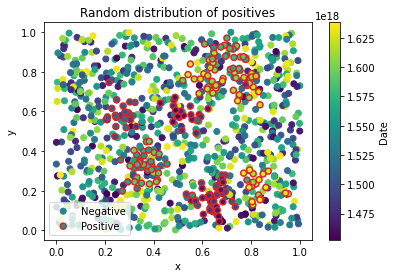

In [17]:
#Plots
plt.scatter(x_rand[test_rand == 0], y_rand[test_rand == 0], c = mock_rand['date'][test_rand == 0], \
            cmap = 'viridis', label = 'Negative')
plt.scatter(x_rand[test_rand == 1], y_rand[test_rand == 1], c = mock_rand['date'][test_rand == 1], \
            cmap = 'viridis', edgecolor = 'tab:red', label = 'Positive', lw = 1.5)
plt.colorbar(label = 'Date')
plt.title("Random distribution of positives")
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [18]:
#Parameters
#linking distance
link_d = .1
#Minimum number of positive cases within link_d to link them
min_neighbours = 2
#Maximum p-value
max_p = .05
#Width of the time window
time_width = 60
#Time steps
time_steps = 5
#Initial date of first time step
min_date = mock_rand['date'].min()
#Final date of last time step
max_date = mock_rand['date'].max()

epi_catalogue_list, mean_date = epifriends.temporal_catalogue(x_rand, y_rand, positive_rand, dates, link_d, min_neighbours, \
                       time_width, min_date, max_date, time_steps, max_p = max_p)
#Number of time steps considered to link their temporal clusters
linking_time = 3
#Spatial distance of clusters within this linking_time to assign the same temporal ID
linking_dist = .15

#Get temporal IDs
epi_catalogue_list = epifriends.add_temporal_id(epi_catalogue_list, linking_time, linking_dist, get_timelife = True)

Data with unknown positions will be excluede from the analysis
missing test results will be kept as unknown for the analysis


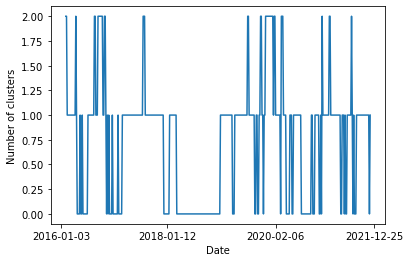

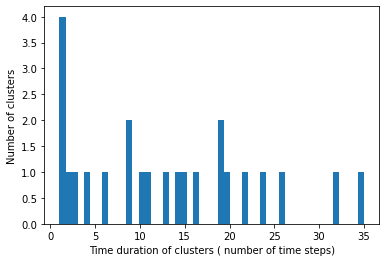

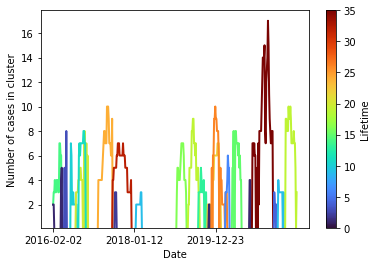

In [19]:
#Showing number of clusters per time step
num_clusters = [len(i) for i in epi_catalogue_list]
plt.plot(mean_date, num_clusters)
plt.xlabel('Date')
plt.ylabel('Number of clusters')
plt.xticks(pd.to_datetime(dates).sort_values()[::int(len(dates)/3)-1])
plt.show()
#Showing histogram of timelifes
hist_timelifes(epi_catalogue_list)
#Showing timeline of cluster sizes
lifetime_timeline(epi_catalogue_list, mean_date, time_steps)

### Additional parameters

The same additional parameters than from the example `epifriends_on_different_distributions.ipynb` can be used here: 


- `max_p`: the maximum p-value considered to output the cluster. Default is 1, meaning that all clusters are kept regardless of p. 

- `min_pos`: the minimum number of positive cases from the cluster to be included. The default is 2. 

- `min_total`: the minimum number of total cases (positive or negative) from the cluster to be included. The default is 2. 

- `min_pr`: the minimum positivity rate (fraction of positive cases) in the cluster to be included in the output. The default is 0, meaning that none are excluded. 

- `in_latlon`: **if the x and y coordinates are given as latitude and longitude,** `in_latlon` **has to be set to** `True`. In this case, x will be interpreted as longitude and y as latitude, and another projection will be used to move the coordinate system to a cartesian coordinate system, with the units of meters.

- `to_epsg`: it is the number of the EPSG coordinate sytem used for the new projection of the data. This can be defined for the desired projection, and if it is left as `None` the value used will be `EPSG=32736`. This one corresponds to the optimal projection for geospatial analysis in Mozambique, where the original data that motivated the development of this method. 

- `keep_null_tests`: this parameter specifies how to deal with the data with missing test results. Three options are possible: 
    
    - `True`: in this case, all the cases are kept, considering the option of having missing test results. They will not affect the first step that identifies clusters of positive cases, but will join those clusters if they are closer than `link_d`. They will contribute to the estimation of the p-value of the foci, that will estimate the probability of finding by chance at least this number of positive cases from the total foci population, and will be included in the total number of individuals from the foci, but not on the number of negative or positive individuals.
    
    - `False`: in this case the data with missing test results will be removed from the analysis, and only complete data will be used. 
    
    - Assigning a numerical value: a numerical value can be assigned to the missing test results. Assigning the value of 0 will be interpreted as considering the missing data as negative results, and assigning the value of 1 will interpret the missing test results as positive. Different values will have uninterpretable consequences, such as estimating unreal numbers of positive cases or positivity rates, and should not be used.